<a href="https://colab.research.google.com/github/nthammadi-uncc/MultiEffects_AirPollutants/blob/main/Notebooks/AP_Multi_Effects_Model_for_Air_Pollutant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-effects Model of Sustainable and Non-Sustainable Electricity Usage and its impact on Carbon Emissions across the US

## Install packages/libraries

In [1]:
#run both R and python 
%load_ext rpy2.ipython

In [2]:
#mount google drive to load pre installs and zipped libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#extract library zip file "ap.library.tar.gz" from location - https://drive.google.com/drive/folders/1z3tM37Cf7zr3hXF5EtPMRnMwdoEb6arm
%cp drive/MyDrive/R_libraries/ap.library.tar.gz .

In [4]:
!du -sh ap.library.tar.gz

552M	ap.library.tar.gz


In [5]:
#copy library to current directory
!tar xf ap.library.tar.gz

tar: Removing leading `/' from member names


In [6]:
%ls usr/local/lib/R/site-library/

abind/           estimability/  inline/       performance/    sjmisc/
arrayhelpers/    fontawesome/   insight/      plyr/           sjPlot/
bayesplot/       future/        IRdisplay/    polyclip/       sjstats/
bayestestR/      ggdag/         IRkernel/     posterior/      sourcetools/
BH/              ggdark/        later/        promises/       StanHeaders/
bridgesampling/  ggdist/        lazyeval/     Rcpp/           svUnit/
brms/            ggeffects/     listenv/      RcppArmadillo/  tensorA/
Brobdingnag/     ggforce/       lme4/         RcppEigen/      threejs/
checkmate/       ggokabeito/    loo/          RcppParallel/   tibble/
cmdstanr/        ggplot2/       markdown/     repr/           tidybayes/
coda/            ggraph/        matrixStats/  reshape2/       tidygraph/
colourpicker/    ggrepel/       miniUI/       rethinking/     tweenr/
crosstalk/       ggridges/      minqa/        rstan/          V8/
dagitty/         globals/       mvtnorm/      rstantools/     viridis/
data

In [7]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [8]:
%%R
.libPaths()

[1] "/content/usr/local/lib/R/site-library"
[2] "/usr/local/lib/R/site-library"        
[3] "/usr/lib/R/site-library"              
[4] "/usr/lib/R/library"                   


###Load packages/libraries

In [9]:
%%R
library(readr)
library(dplyr)
library(tidyverse)
library(magrittr)

library(dagitty)
library(ggdag)
library(ggplot2)
library(ggdark)
library(viridis)
library(lme4)
library(sjPlot)

library(brms)
library(tidybayes)
library(rstan)
library(rethinking)

#library(broom)        # Convert model objects to data frames
#library(broom.mixed)  # Convert brms model objects to data frames
#library(emmeans)      # Calculate marginal effects in even fancier ways
#library(ggh4x)        # For nested facets in ggplot
library(ggrepel)      # For nice non-overlapping labels in ggplot
library(ggdist)       # For distribution-related ggplot geoms
library(scales)       # For formatting numbers with comma(), dollar(), etc.
library(patchwork)    # For combining plots
library(ggokabeito)   # Colorblind-friendly color palette

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: 
Attaching package: ‘ggdag’


R[write to console]: The following obj

In [10]:
%%R
# Make labels use Barlow by default
update_geom_defaults("label_repel", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))
update_geom_defaults("label", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))

### Set seed and any constant variables

In [11]:
%%R
# Make all the random draws reproducible
set.seed(1234)

options(mc.cores = 4)#,  # Use 4 cores
        #brms.backend = "cmdstanr")  # threw an error with Stan
bayes_seed <- 1234

### R version

In [12]:
%%R
R.version.string

[1] "R version 4.2.0 (2022-04-22)"


## Load Data from Github

In [13]:
%%R
#set up data urls from github
data_url <- "https://raw.githubusercontent.com/nthammadi-uncc/MultiEffects_AirPollutants/main/clean_data/electricity_analysis.csv"
#read data
electricity_df <- read_csv(url(data_url))
electricity_df <- electricity_df %>% select(,-...1)

New names:
• `` -> `...1`
Rows: 102 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): STATE, STATE.NAME, REGION, DIVISION, RULING.PARTY, ENERGY.SOURCE
dbl (4): ...1, GENERATION_MM.MWh, CONSUMPTION_MM.MWh.tminus1, CO2.EMISSION_M...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
%%R
#rename columns
names(electricity_df) <- c("state", "state_name", "region", "division","ruling_party","energy_source","generation_MM_MWh","consumption_MM_MWh_tminus1","co2_emissions_mm_metric_tons")

In [15]:
#convert R dataframe to python dataframe
%R -o electricity_df
from IPython.display import display, HTML

display(HTML(electricity_df.to_html()))

,state,state_name,region,division,ruling_party,energy_source,generation_MM_MWh,consumption_MM_MWh_tminus1,co2_emissions_mm_metric_tons
1,AK,Alaska,West,Pacific,REPUBLICAN,Not Sustainable,0.1423,0.1052,2.2050
2,AK,Alaska,West,Pacific,REPUBLICAN,Sustainable,0.3810,15.2853,1.2539
3,AL,Alabama,South,East South Central,REPUBLICAN,Not Sustainable,2.0843,2.6837,21.1638
4,AL,Alabama,South,East South Central,REPUBLICAN,Sustainable,9.3776,256.4072,23.6394
5,AR,Arkansas,South,West South Central,REPUBLICAN,Not Sustainable,1.3599,2.5936,15.5566
6,AR,Arkansas,South,West South Central,REPUBLICAN,Sustainable,3.1931,96.5304,7.8969
7,AZ,Arizona,West,Mountain,DEMOCRAT,Not Sustainable,1.1657,2.4248,14.4691
8,AZ,Arizona,West,Mountain,DEMOCRAT,Sustainable,7.9433,220.9166,21.2452
9,CA,California,West,Pacific,DEMOCRAT,Not Sustainable,0.4081,0.0092,1.2938
10,CA,California,West,Pacific,DEMOCRAT,Sustainable,15.6236,381.0005,41.8743


In [16]:
%%R
summary(electricity_df)

    state            state_name           region            division        
 Length:102         Length:102         Length:102         Length:102        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 ruling_party       energy_source      generation_MM_MWh
 Length:102         Length:102         Min.   : 0.0000  
 Class :character   Class :character   1st Qu.: 0.5374  
 Mode  :character   Mode  :character   Median : 1.6229  
                                       Mean   : 3.2634  
                                       3rd Qu.: 3.8966  
                                       Max.   :32.5472  
 consumption_MM_MWh_tminus1 co2_emissions_mm_metric_tons
 Min.

In [17]:
%%R
str(electricity_df)

tibble [102 × 9] (S3: tbl_df/tbl/data.frame)
 $ state                       : chr [1:102] "AK" "AK" "AL" "AL" ...
 $ state_name                  : chr [1:102] "Alaska" "Alaska" "Alabama" "Alabama" ...
 $ region                      : chr [1:102] "West" "West" "South" "South" ...
 $ division                    : chr [1:102] "Pacific" "Pacific" "East South Central" "East South Central" ...
 $ ruling_party                : chr [1:102] "REPUBLICAN" "REPUBLICAN" "REPUBLICAN" "REPUBLICAN" ...
 $ energy_source               : chr [1:102] "Not Sustainable" "Sustainable" "Not Sustainable" "Sustainable" ...
 $ generation_MM_MWh           : num [1:102] 0.142 0.381 2.084 9.378 1.36 ...
 $ consumption_MM_MWh_tminus1  : num [1:102] 0.105 15.285 2.684 256.407 2.594 ...
 $ co2_emissions_mm_metric_tons: num [1:102] 2.21 1.25 21.16 23.64 15.56 ...


In [18]:
%%R
#convert categorical data to factors
electricity_df$region <- factor(electricity_df$region) 
electricity_df$division <- factor(electricity_df$division) 
electricity_df$ruling_party <- factor(electricity_df$ruling_party) 
electricity_df$energy_source <- factor(electricity_df$energy_source)
electricity_df$state <- factor(electricity_df$state)
str(electricity_df)

tibble [102 × 9] (S3: tbl_df/tbl/data.frame)
 $ state                       : Factor w/ 51 levels "AK","AL","AR",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ state_name                  : chr [1:102] "Alaska" "Alaska" "Alabama" "Alabama" ...
 $ region                      : Factor w/ 4 levels "Midwest","Northeast",..: 4 4 3 3 3 3 4 4 4 4 ...
 $ division                    : Factor w/ 9 levels "East North Central",..: 6 6 2 2 9 9 4 4 6 6 ...
 $ ruling_party                : Factor w/ 2 levels "DEMOCRAT","REPUBLICAN": 2 2 2 2 2 2 1 1 1 1 ...
 $ energy_source               : Factor w/ 2 levels "Not Sustainable",..: 1 2 1 2 1 2 1 2 1 2 ...
 $ generation_MM_MWh           : num [1:102] 0.142 0.381 2.084 9.378 1.36 ...
 $ consumption_MM_MWh_tminus1  : num [1:102] 0.105 15.285 2.684 256.407 2.594 ...
 $ co2_emissions_mm_metric_tons: num [1:102] 2.21 1.25 21.16 23.64 15.56 ...


In [19]:
%%R
#wrangle the data to standardize it
electricity_df <- electricity_df %>% 
    as_tibble() %>%
    mutate(across(where(is.numeric), ~ . - mean(.)))

summary(electricity_df)

     state     state_name              region                 division 
 AK     : 2   Length:102         Midwest  :24   South Atlantic    :18  
 AL     : 2   Class :character   Northeast:18   Mountain          :16  
 AR     : 2   Mode  :character   South    :34   West North Central:14  
 AZ     : 2                      West     :26   New England       :12  
 CA     : 2                                     East North Central:10  
 CO     : 2                                     Pacific           :10  
 (Other):90                                     (Other)           :22  
     ruling_party         energy_source generation_MM_MWh
 DEMOCRAT  :52    Not Sustainable:51    Min.   :-3.2634  
 REPUBLICAN:50    Sustainable    :51    1st Qu.:-2.7260  
                                        Median :-1.6405  
                                        Mean   : 0.0000  
                                        3rd Qu.: 0.6332  
                                        Max.   :29.2838  
                  

### Data Plots

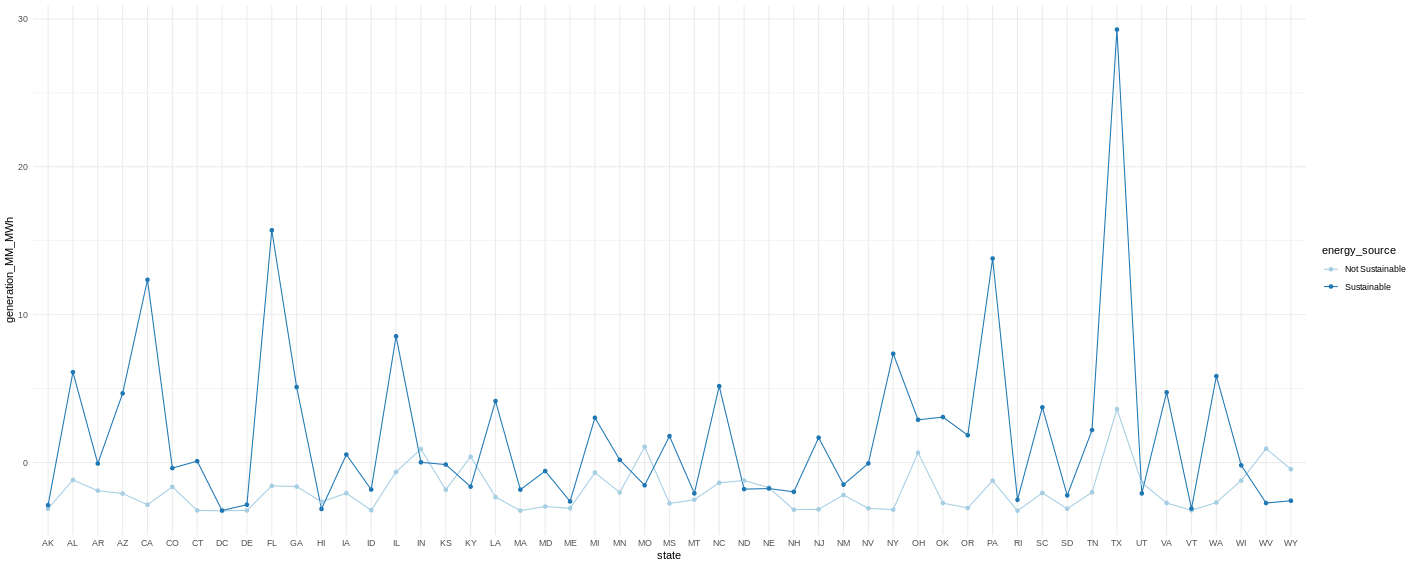

In [20]:
%%R -w 50 -h 20 --units cm 
options(repr.plot.width=50, repr.plot.height=10)
gen <- ggplot(data=electricity_df, aes(x=state, y=generation_MM_MWh, group=energy_source)) +
  geom_line(aes(color=energy_source))+
  geom_point(aes(color=energy_source))
gen <- gen + scale_color_brewer(palette="Paired")+
  theme_minimal()
gen + theme(legend.position="bottom")

gen


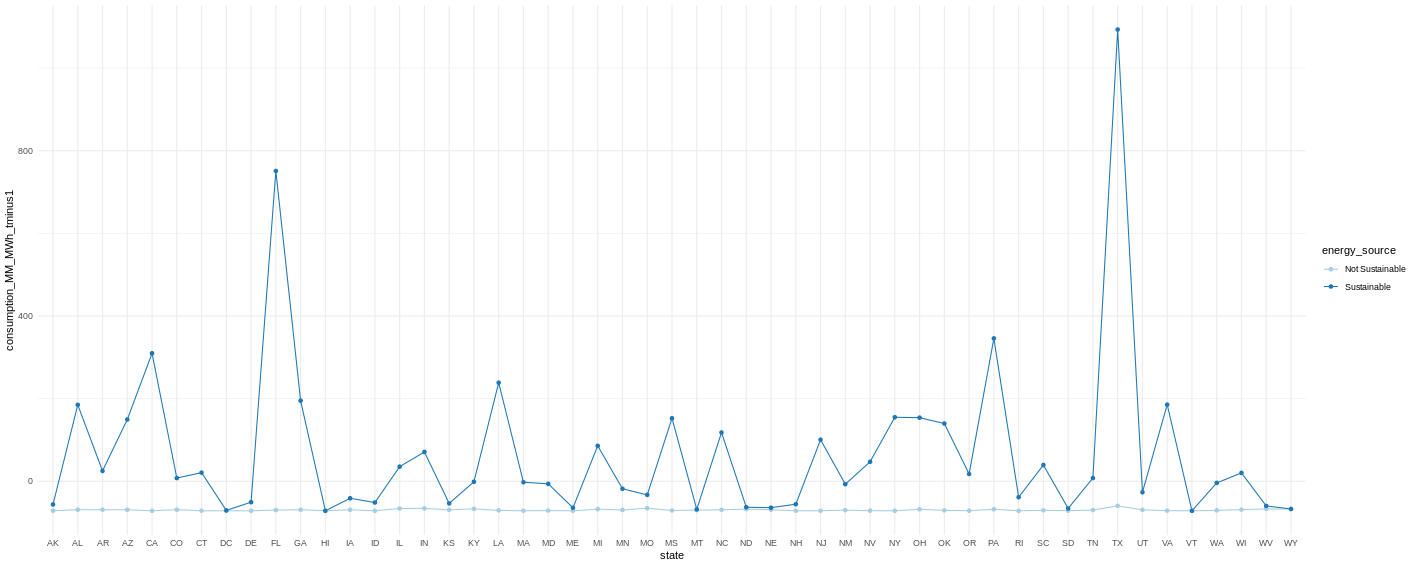

In [21]:
%%R -w 50 -h 20 --units cm 
con <- ggplot(data=electricity_df, aes(x=state, y=consumption_MM_MWh_tminus1, group=energy_source)) +
  geom_line(aes(color=energy_source))+
  geom_point(aes(color=energy_source))
con <- con + scale_color_brewer(palette="Paired")+
  theme_minimal()
con + theme(legend.position="bottom")
options(repr.plot.width=20, repr.plot.height=8)

con

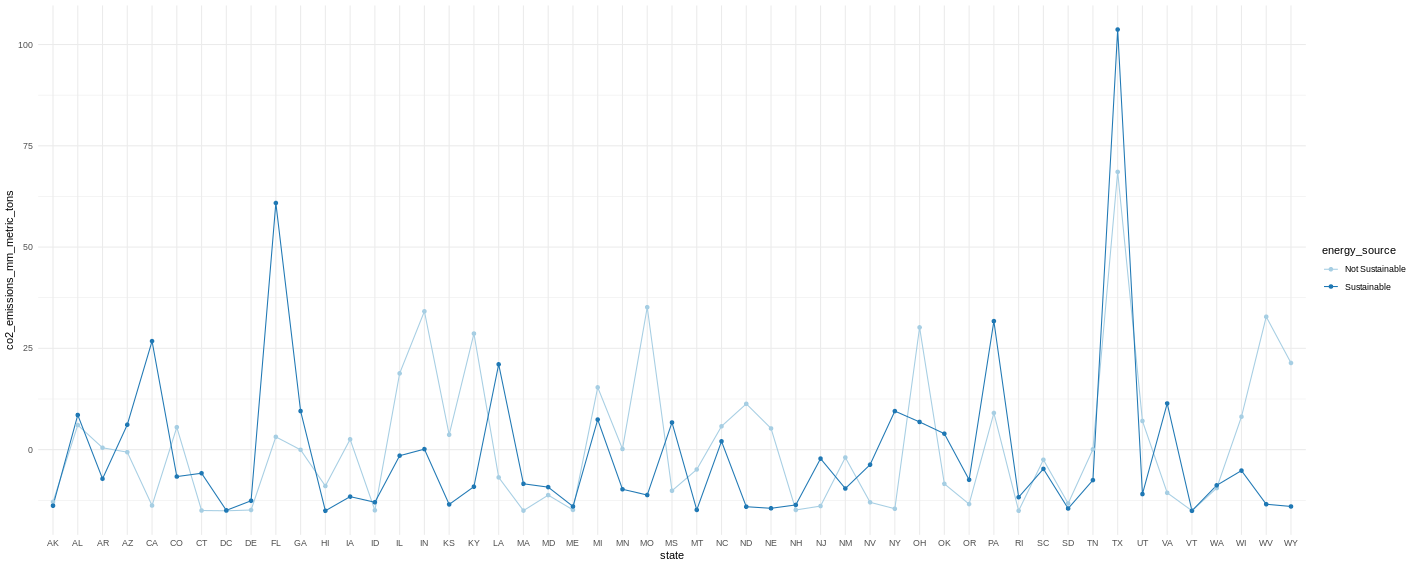

In [22]:
%%R -w 50 -h 20 --units cm 
emi <- ggplot(data=electricity_df, aes(x=state, y=co2_emissions_mm_metric_tons, group=energy_source)) +
  geom_line(aes(color=energy_source))+
  geom_point(aes(color=energy_source))
emi <- emi + scale_color_brewer(palette="Paired")+
  theme_minimal()
emi + theme(legend.position="bottom")
options(repr.plot.width=20, repr.plot.height=8)

emi

R[write to console]: `geom_smooth()` using formula 'y ~ x'



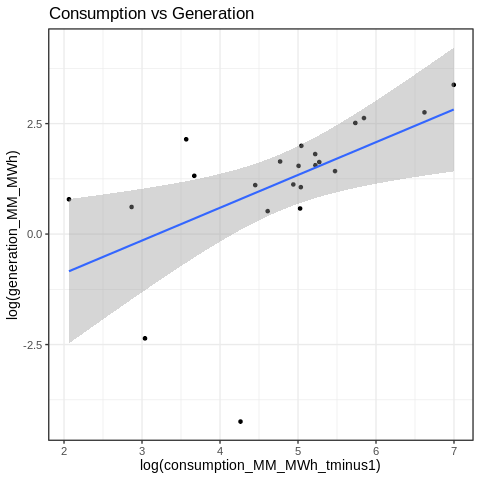

In [23]:
%%R
electricity_df %>% 
  ggplot(aes(log(consumption_MM_MWh_tminus1), log(generation_MM_MWh))) + 
  geom_point() + geom_smooth(method = "lm") + 
  scale_color_brewer(palette = "Set1") + 
  theme_bw(base_size = 14) +
  ggtitle("Consumption vs Generation")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



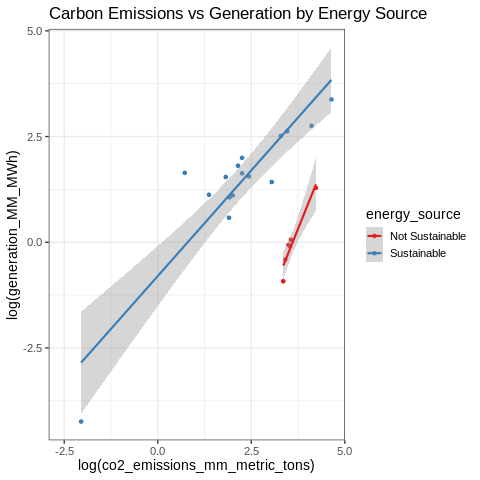

In [24]:
%%R
electricity_df %>% 
  ggplot(aes(log(co2_emissions_mm_metric_tons), log(generation_MM_MWh), color = energy_source)) + 
  geom_point() + geom_smooth(method = "lm") + 
  scale_color_brewer(palette = "Set1") + 
  theme_bw(base_size = 14) +
  ggtitle("Carbon Emissions vs Generation by Energy Source")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



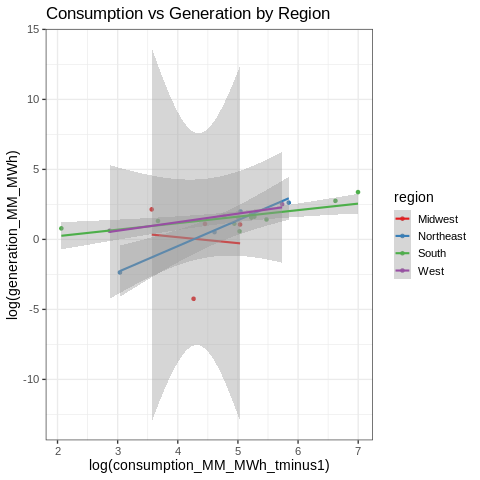

In [25]:
%%R
electricity_df %>% 
  ggplot(aes(log(consumption_MM_MWh_tminus1), log(generation_MM_MWh), color = region)) + 
  geom_point() + geom_smooth(method = "lm") + 
  scale_color_brewer(palette = "Set1") + 
  theme_bw(base_size = 14) +
  ggtitle("Consumption vs Generation by Region")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



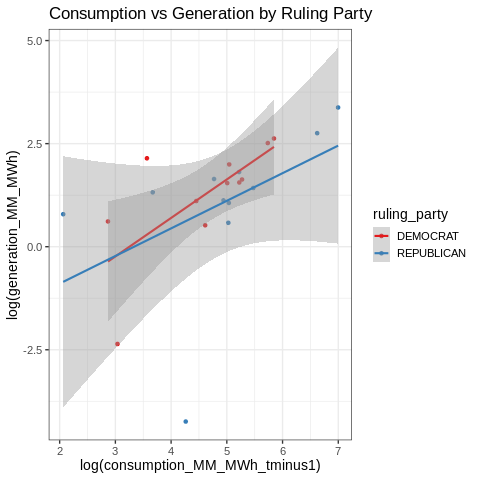

In [26]:
%%R
electricity_df %>% 
  ggplot(aes(log(consumption_MM_MWh_tminus1), log(generation_MM_MWh), color = ruling_party)) + 
  geom_point() + geom_smooth(method = "lm") + 
  scale_color_brewer(palette = "Set1") + 
  theme_bw(base_size = 14) +
  ggtitle("Consumption vs Generation by Ruling Party")

## Causal Inference

### Directed Acyclic Graph (DAG)

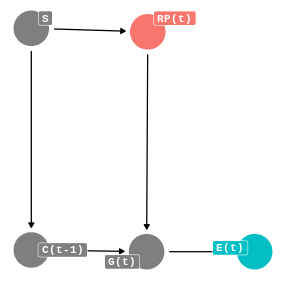

In [27]:
%%R -w 10 -h 10 --units cm 
g <- dagitty('dag {
bb="0,0,1,1"
"C(t-1)" [pos="0.375,0.308"]
"E(t)" [outcome,pos="0.561,0.307"]
"G(t)" [pos="0.471,0.307"]
"RP(t)" [exposure,pos="0.472,0.433"]
S [adjusted,pos="0.375,0.435"]
"C(t-1)" -> "G(t)"
"G(t)" -> "E(t)"
"RP(t)" -> "G(t)"
S -> "C(t-1)"
S -> "RP(t)"
}'
)
ggdag::ggdag_status(g, text = FALSE, use_labels = "name") +
  guides(color = "none") +  # Turn off legend
  theme_dag()

### Total Causal Effect of Ruling Party on Carbon Emissions

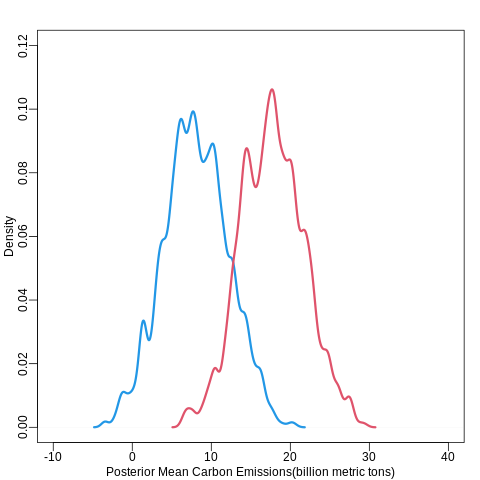

In [28]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  RP = electricity_df$ruling_party,
  E = electricity_df$co2_emissions_mm_metric_tons)

total_causal_model <- 
  quap(
    alist(
        E ~ dnorm( mu , sigma ),
        mu <- a[RP]+bS*S,
        a[RP] ~ dnorm(70,10),
        bS ~ dnorm(0,1),
        sigma ~ dexp(1)
    ), data=dlist )
  
N_sim = 1000 # number of samples
# posterior means
total_causal_post <- extract.samples(total_causal_model, n = N_sim)
dens( total_causal_post$a[,1],xlim=c(-10,40), ylim=c(0,0.12) , lwd=3 , col=4 , xlab="Posterior Mean Carbon Emissions(billion metric tons)" ) # blue - Democrat party
dens( total_causal_post$a[,2], lwd=3 , col=2 , add=TRUE) #red - Republican party

In [29]:
%%R
#output the model
precis(total_causal_model)

R[write to console]: 2 vector or matrix parameters hidden. Use depth=2 to show them.



       mean   sd  5.5% 94.5%
bS    -0.35 0.12 -0.54 -0.15
sigma 18.27 1.28 16.23 20.31


The effect of State is negative (-0.54 to -0.15)

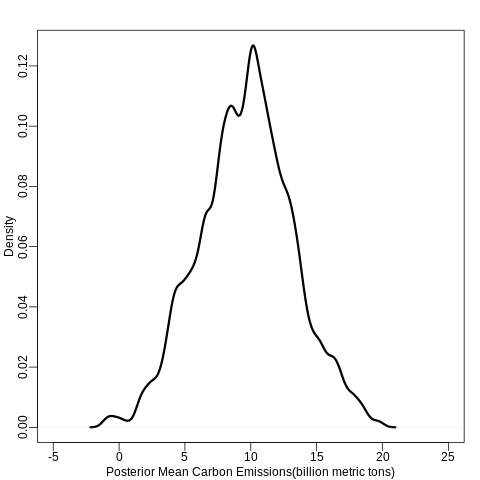

In [30]:
%%R
#calculate the contrast of total effect of ruling party on emissions
total_causal_post_contrast <- total_causal_post$a[,2]-total_causal_post$a[,1]
dens( total_causal_post_contrast,xlim=c(-5,25), lwd=3 , xlab="Posterior Mean Carbon Emissions(billion metric tons)" )

Republican states tend to have a higher mean of carbon emissions

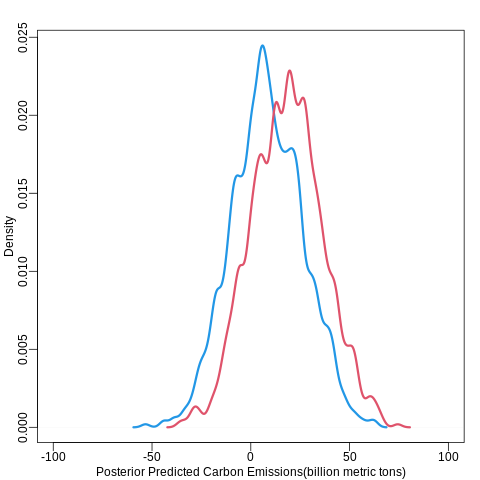

In [31]:
%%R
#posterior emission distributions by ruling party
Emissions_Democrats <- rnorm(N_sim, total_causal_post$a[,1], total_causal_post$sigma)
Emissions_Republican <- rnorm(N_sim, total_causal_post$a[,2], total_causal_post$sigma)
dens( Emissions_Democrats,xlim=c(-100,100) , lwd=3 , col=4 , xlab="Posterior Predicted Carbon Emissions(billion metric tons)" ) # blue - Democrat party
dens( Emissions_Republican, lwd=3 , col=2 , add=TRUE) #red - Republican party

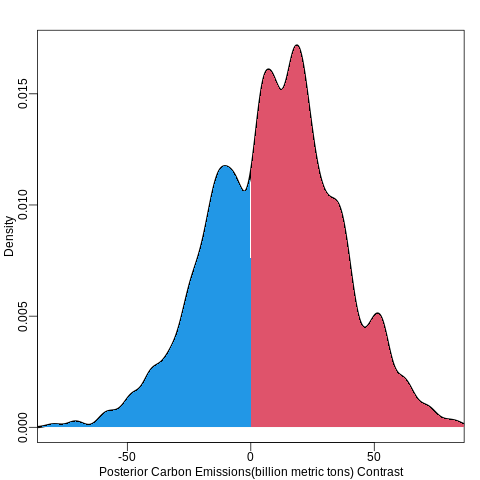

In [32]:
%%R
Emissions_contrast <- Emissions_Republican - Emissions_Democrats
dens( Emissions_contrast , xlim=c(-80,80) , lwd=3 , col=1 , xlab="Posterior Carbon Emissions(billion metric tons) Contrast" )

Emi_dens <- density(Emissions_contrast,adj=0.5)
polygon(c(Emi_dens$x[Emi_dens$x>0], max(Emi_dens$x), 0), c(Emi_dens$y[Emi_dens$x>0], 0, 0), col = 2, border = NA ) # >0 => red -> Republican
polygon(c(Emi_dens$x[Emi_dens$x<0], 0, min(Emi_dens$x)), c(Emi_dens$y[Emi_dens$x<0], 0, 0), col = 4, border = NA ) # <0 => blue -> Democrat


### Direct Causal Effect of Ruling Party on Carbon Emissions

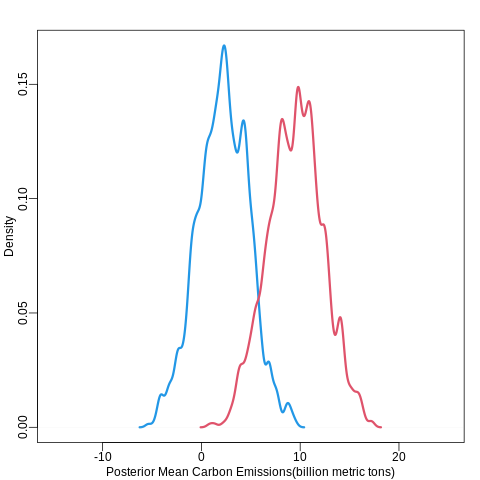

In [33]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  G = electricity_df$generation_MM_MWh, # stratify on Generation to get direct causal effect of Ruling party on Carbon Emissions
  RP = electricity_df$ruling_party,
  E = electricity_df$co2_emissions_mm_metric_tons)

direct_causal_model <- 
  quap(
    alist(
        E ~ dnorm( mu , sigma ),
        mu <- a[RP]+bS*S+bG*G,
        a[RP] ~ dnorm(70,10),
        c(bS,bG) ~ dnorm(0,5),
        sigma ~ dexp(1)
    ), data=dlist )

N_sim = 1000 # number of samples
# posterior means
direct_causal_post <- extract.samples(direct_causal_model, n = N_sim)
dens( direct_causal_post$a[,1],xlim=c(-15,25) , lwd=3 , col=4 , xlab="Posterior Mean Carbon Emissions(billion metric tons)" ) # blue - Democrat party
dens( direct_causal_post$a[,2], lwd=3 , col=2 , add=TRUE) #red - Republican party  

In [34]:
%%R
#output the model
precis(direct_causal_post)

R[write to console]: 2 vector or matrix parameters hidden. Use depth=2 to show them.



quap posterior: 1000 samples from direct_causal_model
       mean   sd  5.5% 94.5%   histogram
bS    -0.16 0.08 -0.28 -0.03  ▁▁▂▅▇▇▅▂▁▁
bG     3.05 0.25  2.65  3.44  ▁▁▁▂▇▇▃▂▁▁
sigma 11.70 0.79 10.46 12.98 ▁▁▁▃▅▇▅▂▁▁▁


The effect of State is negative (-0.28 to -0.03) and that of generation is positive (2.65 to 3.44). This makes sense for generation, since higher the generation, higher the emissions.

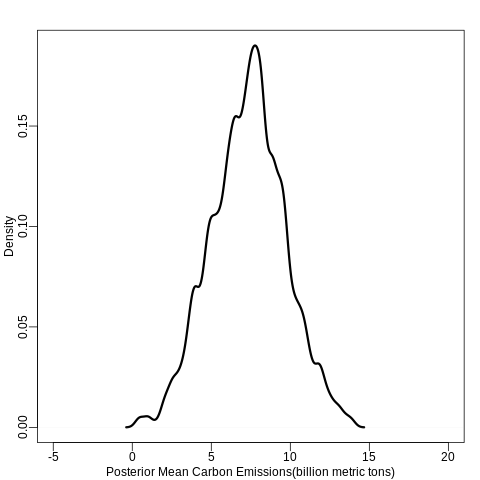

In [35]:
%%R
#calculate the contrast of direct effect of ruling party on emissions
direct_causal_post_contrast <- direct_causal_post$a[,2]-direct_causal_post$a[,1]
dens( direct_causal_post_contrast,xlim=c(-5,20) , lwd=3 , xlab="Posterior Mean Carbon Emissions(billion metric tons)" )

Republican states tend to have a higher mean of carbon emissions

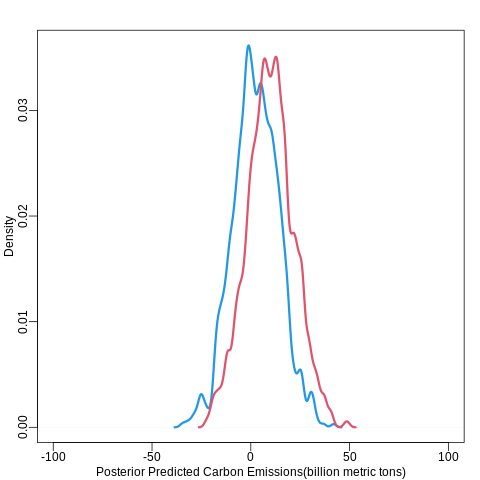

In [36]:
%%R
#posterior emission distributions by ruling party
Emissions_Democrats <- rnorm(N_sim, direct_causal_post$a[,1], direct_causal_post$sigma)
Emissions_Republican <- rnorm(N_sim, direct_causal_post$a[,2], direct_causal_post$sigma)
dens( Emissions_Democrats,xlim=c(-100,100) , lwd=3 , col=4 , xlab="Posterior Predicted Carbon Emissions(billion metric tons)" ) # blue - Democrat party
dens( Emissions_Republican, lwd=3 , col=2 , add=TRUE) #red - Republican party

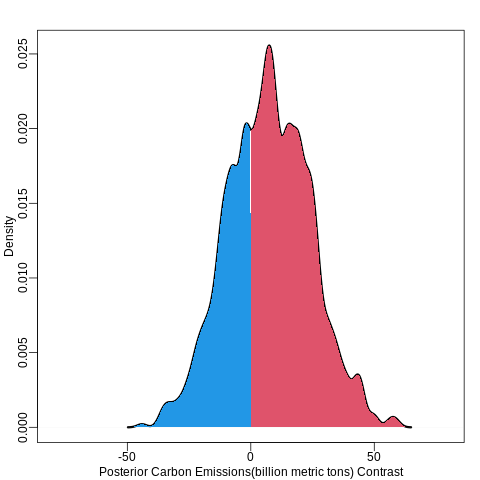

In [37]:
%%R
Emissions_contrast <- Emissions_Republican - Emissions_Democrats
dens( Emissions_contrast , xlim=c(-80,80) , lwd=3 , col=1 , xlab="Posterior Carbon Emissions(billion metric tons) Contrast" )

Emi_dens <- density(Emissions_contrast,adj=0.5)
polygon(c(Emi_dens$x[Emi_dens$x>0], max(Emi_dens$x), 0), c(Emi_dens$y[Emi_dens$x>0], 0, 0), col = 2, border = NA ) # >0 => red -> Republican
polygon(c(Emi_dens$x[Emi_dens$x<0], 0, min(Emi_dens$x)), c(Emi_dens$y[Emi_dens$x<0], 0, 0), col = 4, border = NA ) # <0 => blue -> Democrat

## Predictive Modeling

### Simple Linear Regression with random effects (Frequentist Approach)

In [38]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  G = electricity_df$generation_MM_MWh, 
  C = electricity_df$consumption_MM_MWh_tminus1,
  RP = as.integer(electricity_df$ruling_party), #converted to index variable
  E = electricity_df$co2_emissions_mm_metric_tons)

simple_lm <- 
  lmer(data = dlist, 
      E ~ 1 + S + G + C + ( 1 | RP ) )

In [39]:
%%R
print(simple_lm)

Linear mixed model fit by REML ['lmerMod']
Formula: E ~ 1 + S + G + C + (1 | RP)
   Data: dlist
REML criterion at convergence: 803.6812
Random effects:
 Groups   Name        Std.Dev.
 RP       (Intercept)  4.823  
 Residual             12.070  
Number of obs: 102, groups:  RP, 2
Fixed Effects:
(Intercept)            S            G            C  
   -1.02853      0.04198      3.77375     -0.02361  


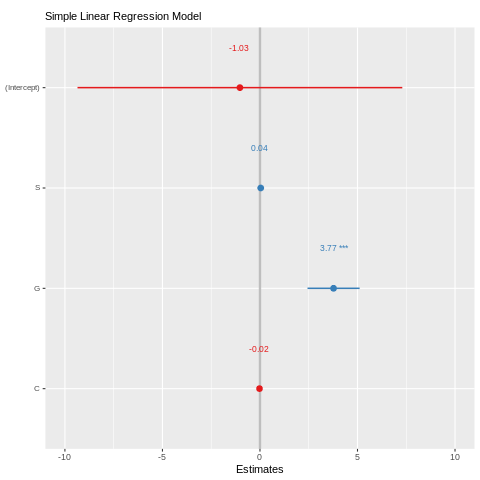

In [40]:
%%R
set.seed(bayes_seed)
lm_plot <- plot_model(simple_lm,show.values = TRUE, vline.color = "grey", value.offset = .4, value.size = 3, type="est", show.intercept = TRUE ) +
  #scale_y_continuous(breaks=seq(-.75,0.75,.25)) +
  theme(axis.text.y = element_text(size = 8),
        plot.subtitle=element_text(size=11), plot.title = element_text(size = 1)) +
  labs(subtitle = "Simple Linear Regression Model", title = "") 

lm_plot

### Bayesian Approach

#### Model 1: Partial pooling with Random Effects on Ruling Party

In [41]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  RP = electricity_df$ruling_party,
  E = electricity_df$co2_emissions_mm_metric_tons)

bayes_mod1 <- 
  brm(data = dlist, 
      family = gaussian,
      E ~ S + ( S | RP ),
      prior = c(prior(normal(0, 0.2 ), class = Intercept),
                prior(normal(0, 0.5), class = b),
                prior(exponential(1), class = sigma)),
      iter = 1000, warmup = 500, cores = 4, chains = 4,
      seed = bayes_seed,
      sample_prior = T,
      # note this line
      save_mevars = TRUE)

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling



In [42]:
%%R
print(bayes_mod1, digits = 2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: E ~ S + (S | RP) 
   Data: dlist (Number of observations: 102) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects: 
~RP (Number of levels: 2) 
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)        5.66      5.65     0.17    20.46 1.01      491      562
sd(S)                0.52      0.53     0.03     1.95 1.01      227      269
cor(Intercept,S)    -0.08      0.61    -0.97     0.94 1.01      346      581

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -2.28      3.98   -10.31     6.18 1.01      384      491
S             0.09      0.15    -0.24     0.40 1.01      382      449

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    17.34      1.15    15.35    19.78 1.00      718      849

D

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Hit <Return> to see next plot: 


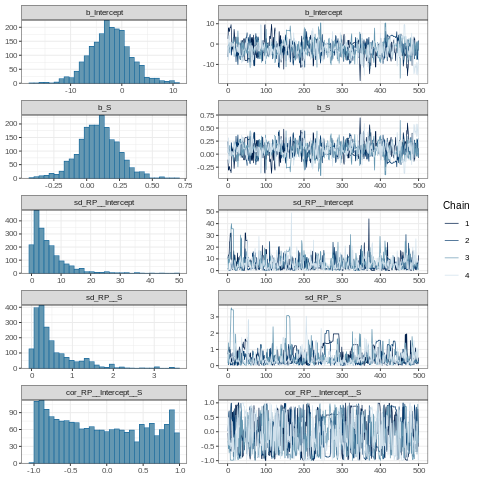

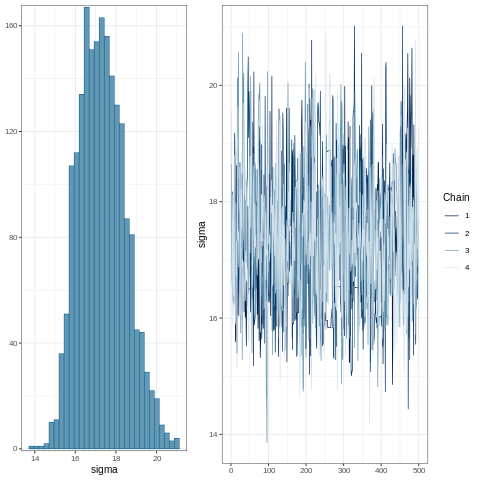

In [43]:
%%R
bayes_mod1 %>% plot(
    combo = c("hist","trace"), widths = c(1,1.5),
    theme = theme_bw(base_size=10)
)

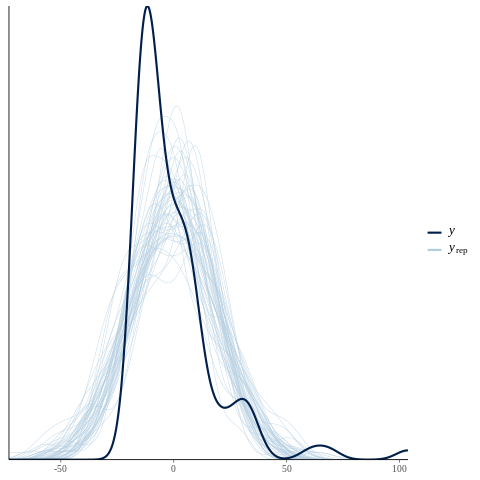

In [44]:
%%R
#sample draws from model 1
pp_check(bayes_mod1, type = "dens_overlay", nsamples = 50)

#### Model 2: Including variables Generation and Consumption of Electricity into Model 1

In [45]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  G = electricity_df$generation_MM_MWh, 
  C = electricity_df$consumption_MM_MWh_tminus1,
  RP = electricity_df$ruling_party,
  E = electricity_df$co2_emissions_mm_metric_tons)

bayes_mod2 <- 
  brm(data = dlist, 
      family = gaussian,
      E ~ S + G + C + ( S | RP ),
      prior = c(prior(normal(0, 0.2 ), class = Intercept),
                prior(normal(0, 0.5), class = b),
                prior(exponential(1), class = sigma)),
      iter = 1000, warmup = 500, cores = 4, chains = 4,
      seed = bayes_seed,
      sample_prior = T,
      # note this line
      save_mevars = TRUE)

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling



In [46]:
%%R
print(bayes_mod2, digits = 2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: E ~ S + G + C + (S | RP) 
   Data: dlist (Number of observations: 102) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects: 
~RP (Number of levels: 2) 
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)        5.23      4.84     0.19    18.26 1.00      660      633
sd(S)                0.33      0.30     0.02     1.18 1.01      588      440
cor(Intercept,S)    -0.03      0.59    -0.95     0.95 1.00      768      992

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.81      3.00    -7.60     4.42 1.00      720      825
S             0.07      0.12    -0.17     0.29 1.00      714      850
G             1.30      0.42     0.49     2.07 1.00      778     1317
C             0.04      0.01     0.02     0.07 1.01     1050     1040

Family Specific

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Hit <Return> to see next plot: 


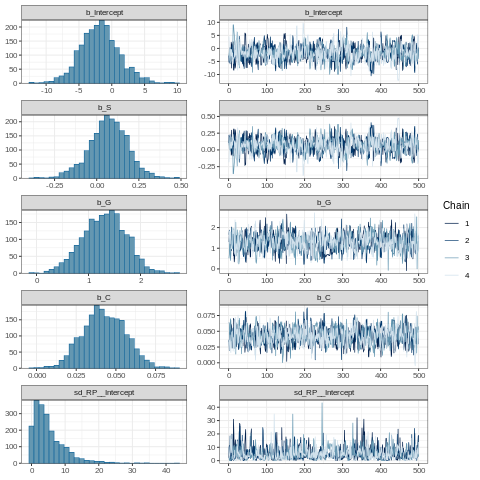

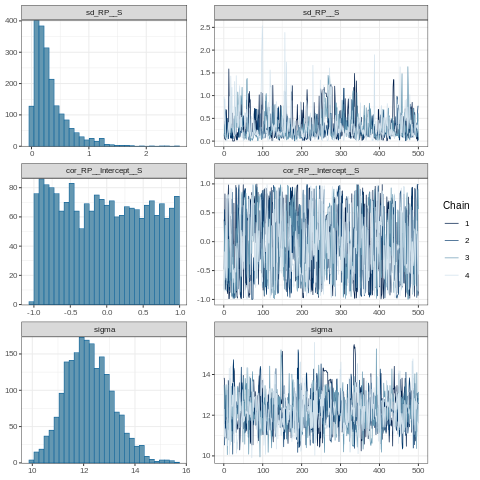

In [47]:
%%R
bayes_mod2 %>% plot(
    combo = c("hist","trace"), widths = c(1,1.5),
    theme = theme_bw(base_size=10)
)

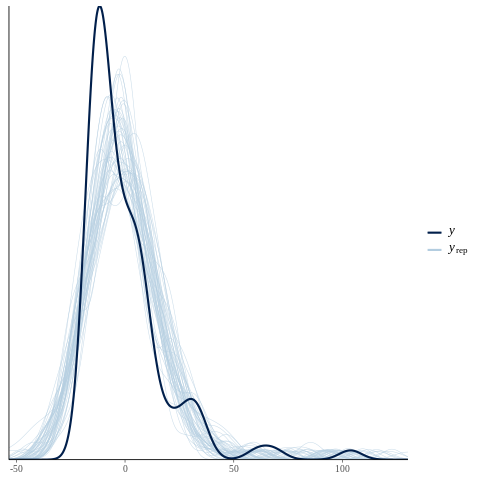

In [48]:
%%R
#sample draws from model 2
pp_check(bayes_mod2, type = "dens_overlay", nsamples = 50)

#### Model 3: Partial Pooling Mixed Effects with global intercept and group effects

In [49]:
%%R
set.seed(bayes_seed)
# put the data into a `list()`
dlist <- list(
  S = as.integer(electricity_df$state), #converted to index variable
  G = electricity_df$generation_MM_MWh, 
  C = electricity_df$consumption_MM_MWh_tminus1,
  RP = electricity_df$ruling_party,
  E = electricity_df$co2_emissions_mm_metric_tons)

bayes_mod3 <- 
  brm(data = dlist, 
      family = gaussian,
      E ~ 1 + S + G + C + ( 1 | RP ),
      prior = c(prior(normal(0, 0.2 ), class = Intercept),
                prior(normal(0, 0.5), class = b),
                prior(exponential(1), class = sigma)),
      iter = 1000, warmup = 500, cores = 4, chains = 4,
      seed = bayes_seed,
      sample_prior = T,
      # note this line
      save_mevars = TRUE)

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling



In [50]:
%%R
print(bayes_mod3, digits = 2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: E ~ 1 + S + G + C + (1 | RP) 
   Data: dlist (Number of observations: 102) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects: 
~RP (Number of levels: 2) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     6.14      4.98     0.72    19.59 1.00      520      587

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.94      2.09    -5.96     2.17 1.00     1637     1223
S             0.07      0.08    -0.08     0.23 1.00     1646     1146
G             1.34      0.42     0.45     2.15 1.00     1065      918
C             0.04      0.01     0.02     0.07 1.00     1066     1104

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    12.19      0.87    10.65    14.08 1.00     1286     1081

Draws wer

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Hit <Return> to see next plot: 


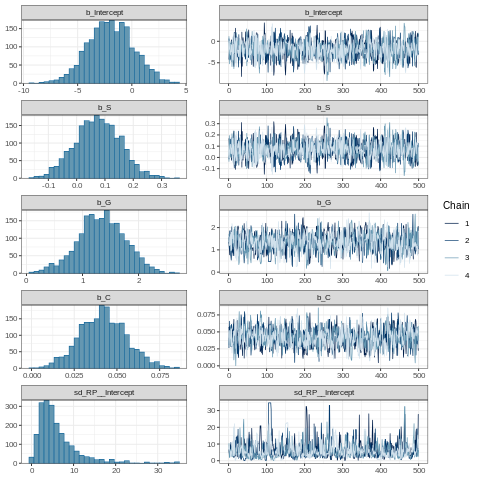

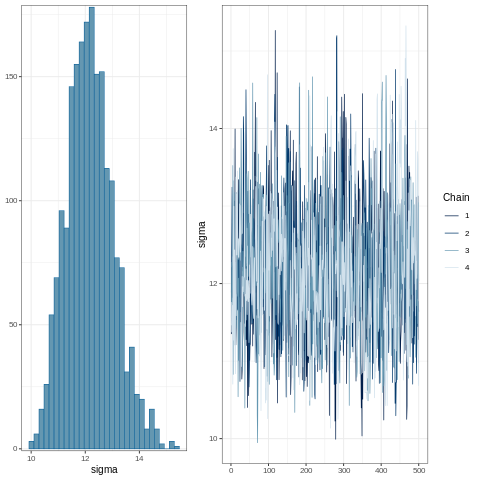

In [51]:
%%R
bayes_mod3 %>% plot(
    combo = c("hist","trace"), widths = c(1,1.5),
    theme = theme_bw(base_size=10)
)

### Model Comparisons

In [ ]:
%%R
psis_mod1 <- loo(bayes_mod1, save_psis = TRUE)
psis_mod2 <- loo(bayes_mod2, save_psis = TRUE)
psis_mod3 <- loo(bayes_mod3, save_psis = TRUE)
loo_compare(psis_mod1,psis_mod2,psis_mod3)